In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/
!ls

/content
drive  sample_data


In [ ]:
!cp -r /content/drive/MyDrive/ece570/MyDiffusion /content/

In [ ]:
%cd /content/MyDiffusion/

In [ ]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
from utils import *
from modules import UNet_conditional, EMA
import logging
from torch.utils.tensorboard import SummaryWriter

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


In [ ]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        coefficient_epsilon = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + coefficient_epsilon * epsilon, epsilon

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x


In [ ]:
def train(start_epoch = 1,run_name = "DDPM_conditional",epochs = 400,batch_size = 10,image_size = 64,num_classes = 10,dataset_path = "img",device = "cuda",lr = 3e-4):

    setup_logging(run_name)

    start_epoch = start_epoch

    if torch.cuda.is_available() :
        device = "cuda"
    else :
        device = "cpu"
    #device = 'cpu'
    print(device)

    dataloader = get_data(image_size,dataset_path,batch_size)
    model = UNet_conditional(size = image_size,num_classes=num_classes,device=device).to(device)
    checkpoint_model = torch.load("/content/drive/MyDrive/ece570/MyDiffusion/models/DDPM_conditional/ckpt.pt", map_location=device)
    model.load_state_dict(checkpoint_model)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    optimizer.load_state_dict(
        torch.load("/content/drive/MyDrive/ece570/MyDiffusion/models/DDPM_conditional/optim.pt", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", run_name))
    l = len(dataloader)
    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)
    checkpoint_ema = torch.load("/content/drive/MyDrive/ece570/MyDiffusion/models/DDPM_conditional/ema_ckpt.pt", map_location=device)
    ema_model.load_state_dict(checkpoint_ema)

    for epoch in range(start_epoch,epochs):
        logging.info(f"Starting epoch {epoch}:")
        print(epoch)
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None
            predicted_noise = model(x_t, t, labels)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step_ema(ema_model, model)

            pbar.set_postfix(MSE=loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        if epoch % 10 == 0:
            labels = torch.arange(10).long().to(device)
            sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
            ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
            plot_images(sampled_images)
            save_images(sampled_images, os.path.join("/content/drive/MyDrive/ece570/MyDiffusion/results", run_name, f"{epoch}.jpg"))
            save_images(ema_sampled_images, os.path.join("/content/drive/MyDrive/ece570/MyDiffusion/results", run_name, f"{epoch}_ema.jpg"))
            torch.save(model.state_dict(), os.path.join("/content/drive/MyDrive/ece570/MyDiffusion/models", run_name, f"ckpt.pt"))
            torch.save(ema_model.state_dict(), os.path.join("/content/drive/MyDrive/ece570/MyDiffusion/models", run_name, f"ema_ckpt.pt"))
            torch.save(optimizer.state_dict(), os.path.join("/content/drive/MyDrive/ece570/MyDiffusion/models", run_name, f"optim.pt"))



In [ ]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device='cuda', abbreviated=False))


True
cuda


<ipython-input-8-685622825423>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model = torch.load("/content/drive/MyDrive/ece570/Diffusion-Models-pytorch-main/m

291


100%|██████████| 5000/5000 [30:46<00:00,  2.71it/s, MSE=0.015]


292


100%|██████████| 5000/5000 [30:48<00:00,  2.71it/s, MSE=0.0126]


293


100%|██████████| 5000/5000 [30:47<00:00,  2.71it/s, MSE=0.00962]


294


100%|██████████| 5000/5000 [30:47<00:00,  2.71it/s, MSE=0.0057]


295


100%|██████████| 5000/5000 [30:48<00:00,  2.70it/s, MSE=0.003]


296


100%|██████████| 5000/5000 [30:48<00:00,  2.71it/s, MSE=0.0212]


297


100%|██████████| 5000/5000 [30:49<00:00,  2.70it/s, MSE=0.00889]


298


100%|██████████| 5000/5000 [30:46<00:00,  2.71it/s, MSE=0.0083]


299


100%|██████████| 5000/5000 [30:47<00:00,  2.71it/s, MSE=0.0034]


300


100%|██████████| 5000/5000 [30:45<00:00,  2.71it/s, MSE=0.00469]
999it [04:16,  3.90it/s]
999it [04:16,  3.90it/s]


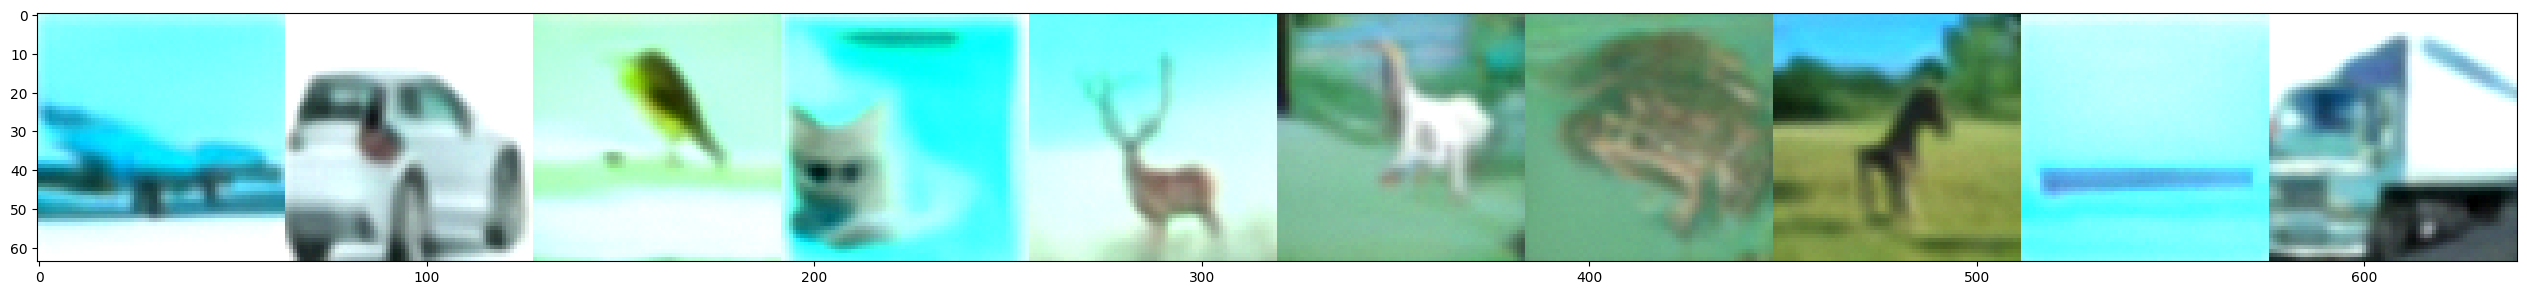

301


100%|██████████| 5000/5000 [30:48<00:00,  2.70it/s, MSE=0.0168]


302


100%|██████████| 5000/5000 [30:49<00:00,  2.70it/s, MSE=0.0306]


303


100%|██████████| 5000/5000 [30:49<00:00,  2.70it/s, MSE=0.0156]


304


100%|██████████| 5000/5000 [30:47<00:00,  2.71it/s, MSE=0.00816]


305


100%|██████████| 5000/5000 [30:47<00:00,  2.71it/s, MSE=0.00605]


306


100%|██████████| 5000/5000 [30:48<00:00,  2.70it/s, MSE=0.00909]


307


100%|██████████| 5000/5000 [30:48<00:00,  2.70it/s, MSE=0.00936]


308


100%|██████████| 5000/5000 [30:48<00:00,  2.71it/s, MSE=0.00856]


309


100%|██████████| 5000/5000 [30:47<00:00,  2.71it/s, MSE=0.0136]


310


100%|██████████| 5000/5000 [30:49<00:00,  2.70it/s, MSE=0.00734]
999it [04:16,  3.90it/s]
999it [04:16,  3.90it/s]


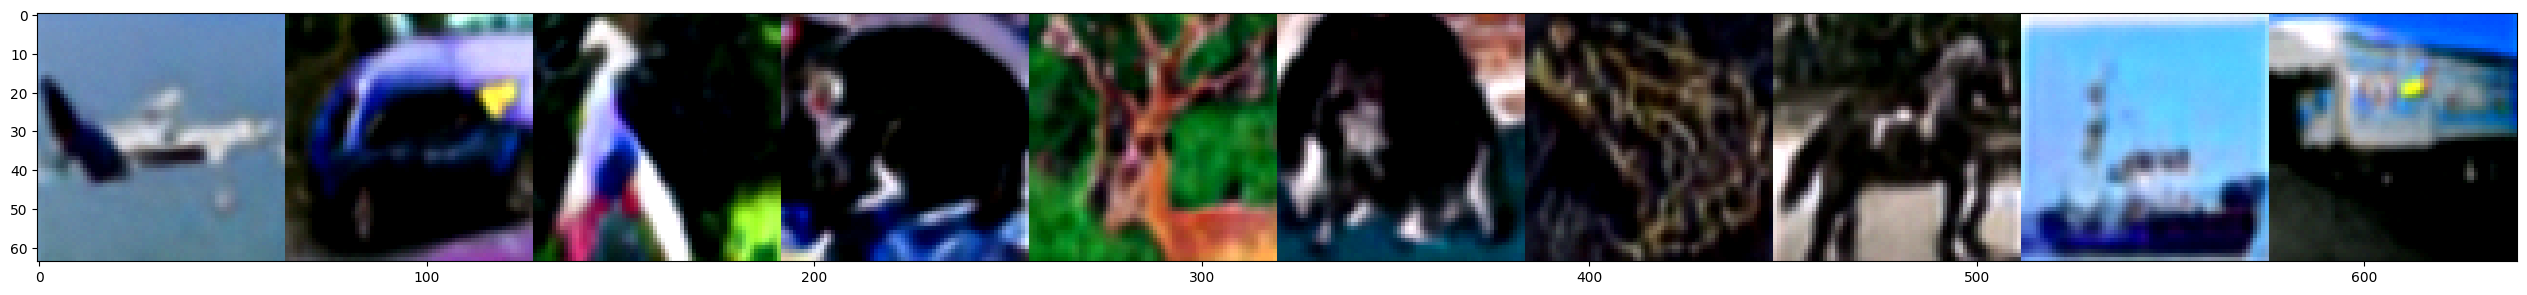

311


100%|██████████| 5000/5000 [30:50<00:00,  2.70it/s, MSE=0.00659]


312


100%|██████████| 5000/5000 [30:50<00:00,  2.70it/s, MSE=0.0124]


313


100%|██████████| 5000/5000 [30:49<00:00,  2.70it/s, MSE=0.00984]


314


100%|██████████| 5000/5000 [30:49<00:00,  2.70it/s, MSE=0.00576]


315


100%|██████████| 5000/5000 [30:49<00:00,  2.70it/s, MSE=0.0121]


316


100%|██████████| 5000/5000 [30:49<00:00,  2.70it/s, MSE=0.0126]


317


100%|██████████| 5000/5000 [30:51<00:00,  2.70it/s, MSE=0.00616]


318


100%|██████████| 5000/5000 [30:53<00:00,  2.70it/s, MSE=0.0133]


319


100%|██████████| 5000/5000 [30:50<00:00,  2.70it/s, MSE=0.0142]


320


100%|██████████| 5000/5000 [30:52<00:00,  2.70it/s, MSE=0.014]
999it [04:16,  3.90it/s]
999it [04:16,  3.90it/s]


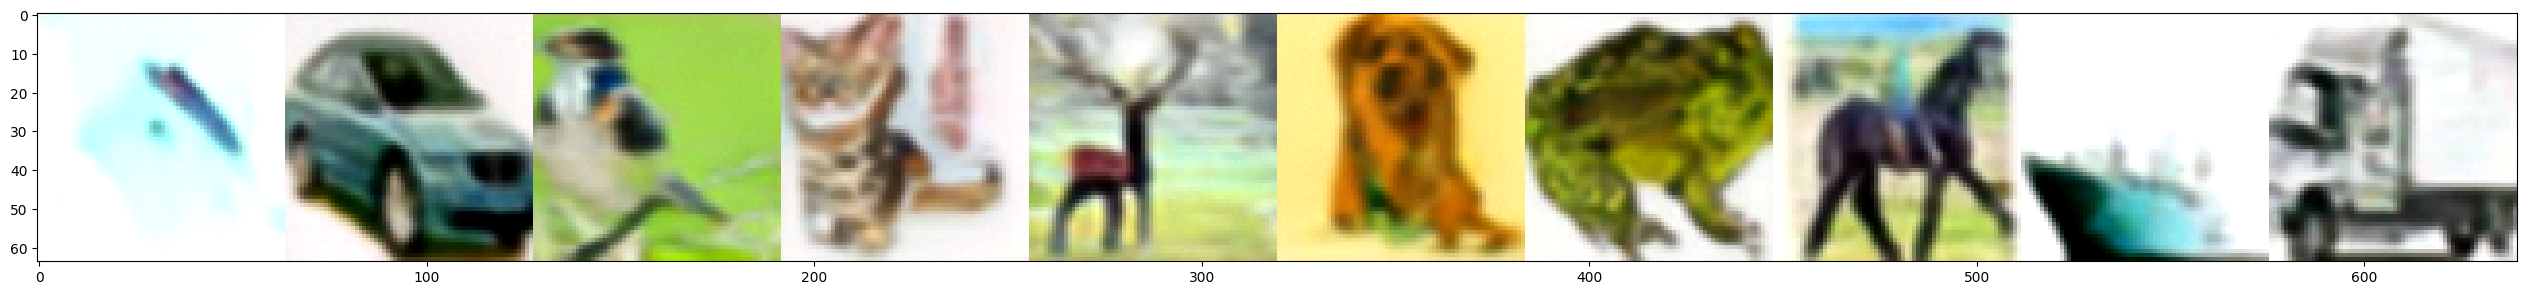

321


100%|██████████| 5000/5000 [30:52<00:00,  2.70it/s, MSE=0.00723]


322


100%|██████████| 5000/5000 [30:52<00:00,  2.70it/s, MSE=0.00664]


323


100%|██████████| 5000/5000 [30:51<00:00,  2.70it/s, MSE=0.0458]


324


100%|██████████| 5000/5000 [30:49<00:00,  2.70it/s, MSE=0.00559]


325


100%|██████████| 5000/5000 [30:49<00:00,  2.70it/s, MSE=0.00955]


326


100%|██████████| 5000/5000 [30:51<00:00,  2.70it/s, MSE=0.00586]


327


100%|██████████| 5000/5000 [30:51<00:00,  2.70it/s, MSE=0.0082]


328


100%|██████████| 5000/5000 [30:49<00:00,  2.70it/s, MSE=0.00801]


329


100%|██████████| 5000/5000 [30:51<00:00,  2.70it/s, MSE=0.00892]


330


100%|██████████| 5000/5000 [30:53<00:00,  2.70it/s, MSE=0.00678]
999it [04:16,  3.90it/s]
999it [04:16,  3.90it/s]


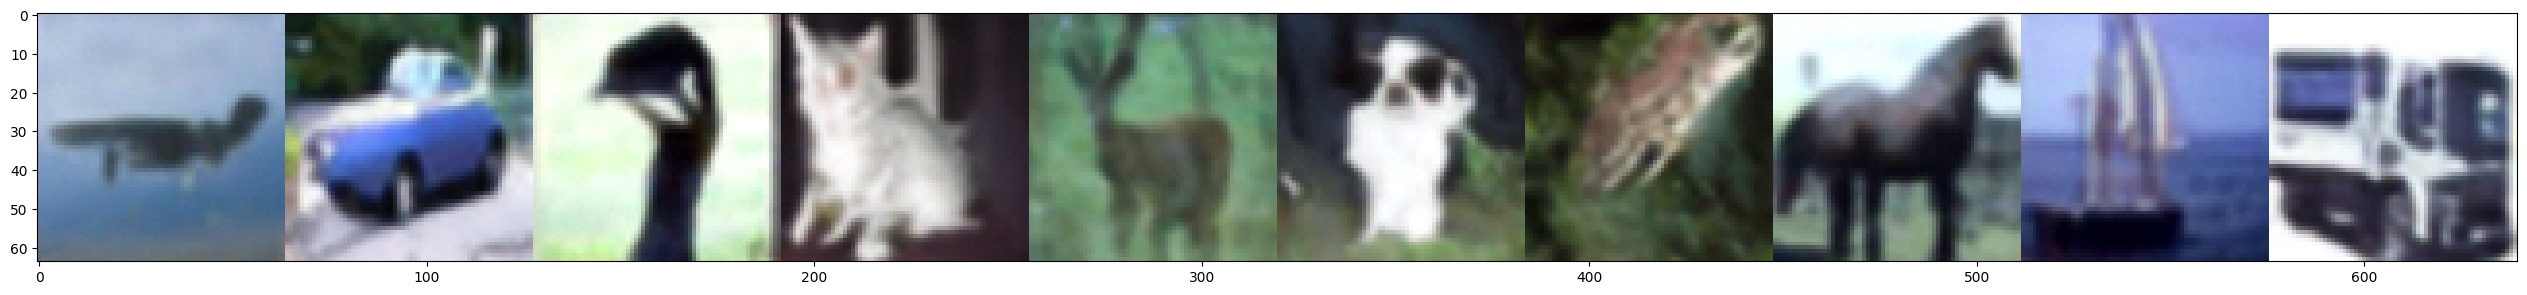

331


100%|██████████| 5000/5000 [30:50<00:00,  2.70it/s, MSE=0.0213]


332


 72%|███████▏  | 3580/5000 [22:04<08:45,  2.70it/s, MSE=0.0117]

In [ ]:
import torch
print(torch.cuda.is_available())  # Should print True if CUDA is available
torch.cuda.empty_cache()
train(start_epoch=291)